In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
from torchsummary import summary

import torchmetrics

import pytorch_lightning as pl

from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

In [2]:
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.InstanceNorm2d(planes, affine=True)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.InstanceNorm2d(planes, affine=True)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.InstanceNorm2d(planes * 4, affine=True)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out




class ResNet(nn.Module):

    def __init__(self, block, layers, out_layers=32):
        self.inplanes = 64
        in_dim = 3
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(in_dim, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.InstanceNorm2d(64, affine=True)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.final = nn.Conv2d(2048, out_layers, 3, stride=2)
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, (2. / n)**.5)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.InstanceNorm2d(planes * block.expansion, affine=True),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.final(x)

        return x

In [3]:
def conv3x3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1, dilation: int = 1, output_padding: int = 0) -> nn.Conv2d:
    """3x3 convolution with padding"""
    return nn.ConvTranspose2d(
        in_planes,
        out_planes,
        kernel_size=3,
        stride=stride,
        padding=dilation,
        output_padding = output_padding,
        groups=groups,
        bias=False,
        dilation=dilation,
    )


def conv1x1(in_planes: int, out_planes: int, stride: int = 1, output_padding: int = 0) -> nn.Conv2d:
    """1x1 convolution"""
    return nn.ConvTranspose2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False, output_padding = output_padding)


class BottleneckT(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition"https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion: int = 4

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        output_padding: int = 0,
        upsample = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.InstanceNorm2d
        width = int(planes * (base_width / 64.0)) * groups
        # Both self.conv2 and self.upsample layers upsample the input when stride != 1
        self.conv3 = conv1x1(planes * self.expansion, width)
        self.bn3 = norm_layer(planes)

        self.conv2 = conv3x3(width, width, stride, groups, dilation, output_padding)
        self.bn2 = norm_layer(width)

        self.conv1 = conv1x1(width, inplanes)
        self.bn1 = norm_layer(inplanes)
        
        
        self.relu = nn.ReLU(inplace=True)
        self.upsample = upsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv3(x)
        out = self.bn3(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv1(out)
        out = self.bn1(out)
        if self.upsample is not None:
            identity = self.upsample(x)
        out += identity
        out = self.relu(out)

        return out


class ResNetT(nn.Module):
    def __init__(
        self,
        block,
        layers,
        inp_channels=32,
        zero_init_residual: bool = False,
        groups: int = 1,
        width_per_group: int = 64,
        norm_layer = None,
        # indices = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = lambda x: nn.InstanceNorm2d(x, affine=True)
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        self.groups = groups
        self.base_width = width_per_group
        self.bn1 = norm_layer(3)
        self.relu = nn.ReLU(inplace=True)
        
        self.increase_channels = nn.Sequential(
            conv1x1(inp_channels, 256, stride=2),
            conv1x1(256, 2048, stride=2, output_padding=1)
        )
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer1 = self._make_layer(block, 64, layers[0], stride=2)
        self.final = conv3x3(128, 3, stride=2, output_padding=1)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck) and m.bn3.weight is not None:
                    nn.init.constant_(m.bn3.weight, 0)  # type: ignore[arg-type]
                elif isinstance(m, BasicBlock) and m.bn2.weight is not None:
                    nn.init.constant_(m.bn2.weight, 0)  # type: ignore[arg-type]

    def _make_layer(
        self,
        block,
        planes: int,
        blocks: int,
        stride: int = 1,
        output_padding: int = 1,
        last_block_dim: int = 0,
    ) -> nn.Sequential:
        norm_layer = self._norm_layer
        upsample = None
        previous_dilation = self.dilation

        layers = []
        self.inplanes = planes * block.expansion
        if last_block_dim == 0:
            last_block_dim = self.inplanes//2
        if stride != 1 or self.inplanes != planes * block.expansion or output_padding==0:
            upsample = nn.Sequential(
                conv1x1(planes * block.expansion, last_block_dim, stride, output_padding),
                # norm_layer(planes * block.expansion),
                norm_layer(last_block_dim),
            )
        last_block = block(
                last_block_dim, planes, stride, output_padding, upsample, self.groups, self.base_width, previous_dilation, norm_layer
            )
        
        for _ in range(1, blocks):
            layers.append(
                block(
                    self.inplanes,
                    planes,
                    groups=self.groups,
                    base_width=self.base_width,
                    dilation=self.dilation,
                    norm_layer=norm_layer,
                )
            )
        layers.append(last_block)
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.increase_channels(x)
        x = self.layer4(x)
        x = self.layer3(x)
        x = self.layer2(x)
        x = self.layer1(x)
        x = self.final(x)
        return x


In [4]:
import math

MAX_TOKEN = 8

class Autoenc(pl.LightningModule):
    def __init__(self, enc, dec, lr=1e-3, batch_size=256):
        super().__init__()
        self.enc = enc
        self.dec = dec
        self.lr = lr
        self.batch_size = batch_size
    
    def training_step(self, batch, batch_idx):
        inputs, labels = batch
        bs, ch, height, width = inputs.shape
        
        rec = torch.zeros_like(inputs)
        aux_loss = 0
        n_tokens = min(1 + self.current_epoch//3, MAX_TOKEN)
        for j in range(n_tokens): 
            err = inputs-rec
            mean, std = torch.mean(err, dim=(-1,-2), keepdims=True), torch.std(err, dim=(-1,-2), keepdims=True)
            z = self.enc((err-mean)/std)
            rec = rec+(self.dec(z)*std + mean)
            aux_loss += F.mse_loss(inputs, rec)
            
        aux_loss /= n_tokens
        loss = F.mse_loss(inputs, rec)
        
        self.log('train_loss', aux_loss, on_step=True, on_epoch=False)
        self.log('train_fin_loss', loss, on_step=True, on_epoch=False)
        ep = min(self.current_epoch/20, 0.5)
        return loss * ep + aux_loss * (1-ep)
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=1/3, patience=10, min_lr=1e-5, verbose=True),
                "monitor": "train_loss",
                "frequency": 1
            },
        }
        
    def setup(self, stage=None):
        # Assign train/val datasets for use in dataloaders
        if stage == "fit" or stage is None:
            transform = transforms.Compose([
                transforms.Resize((192,192)),
                transforms.ToTensor(), 
                transforms.Normalize((0.5, 0.5, 0.5), (1.0,1.0,1.0)), 
            ])

            self.trainset = torchvision.datasets.CelebA("/pscratch/sd/a/andigu/data", transform=transform, split="all")
            
    def train_dataloader(self):
        return torch.utils.data.DataLoader(self.trainset, batch_size=self.batch_size, shuffle=True, num_workers=32)

In [39]:
channels = 16
in_layers = 64
enc = nn.Sequential(
    nn.Conv2d(3, in_layers, 4, stride=2, padding=1),            # [batch, 12, 16, 16]
    nn.GELU(),
    nn.Conv2d(in_layers, in_layers*2, 4, stride=2, padding=1),           # [batch, 24, 8, 8]
    nn.GELU(),
    nn.Conv2d(in_layers*2, in_layers*4, 4, stride=2, padding=1),           # [batch, 48, 4, 4]
    nn.GELU(),
    nn.Conv2d(in_layers*4, in_layers*8, 4, stride=2, padding=1),           # [batch, 48, 4, 4]
    nn.GELU(),
    nn.Conv2d(in_layers*8, in_layers*16, 4, stride=2, padding=1),           # [batch, 48, 4, 4]
    nn.GELU(),
    nn.Conv2d(in_layers*16, channels, 4, stride=2, padding=1),           # [batch, 48, 4, 4]
)

dec = nn.Sequential(
    nn.ConvTranspose2d(channels, in_layers*16, 4, stride=2, padding=1),  # [batch, 48, 4, 4]
    nn.GELU(),
    nn.ConvTranspose2d(in_layers*16, in_layers*8, 4, stride=2, padding=1),  # [batch, 24, 8, 8]
    nn.GELU(),
    nn.ConvTranspose2d(in_layers*8, in_layers*4, 4, stride=2, padding=1),  # [batch, 24, 8, 8]
    nn.GELU(),
    nn.ConvTranspose2d(in_layers*4, in_layers*2, 4, stride=2, padding=1),  # [batch, 24, 8, 8]
    nn.GELU(),
    nn.ConvTranspose2d(in_layers*2, in_layers, 4, stride=2, padding=1),  # [batch, 24, 8, 8]
    nn.GELU(),
    nn.ConvTranspose2d(in_layers, 3, 4, stride=2, padding=1),  # [batch, 12, 16, 16]
)

autoenc = Autoenc(enc, dec, batch_size=512, lr=2e-4)

In [40]:
from pytorch_lightning.callbacks import TQDMProgressBar, ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger, TensorBoardLogger
callbacks = [
    TQDMProgressBar(refresh_rate=1),
    ModelCheckpoint(monitor='train_fin_loss', save_top_k=2)
]
conf_name = "res-learn-celeb"
logger = CSVLogger("logs", name=conf_name)
trainer = pl.Trainer(callbacks=callbacks, max_epochs=2000, accelerator="gpu", devices=4, strategy="dp",
                     logger=logger, auto_scale_batch_size=None, auto_lr_find=False,
                     log_every_n_steps=20, gradient_clip_val=0.1)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [41]:
trainer.tune(model=autoenc)

{}

In [ ]:
trainer.fit(model=autoenc)#, ckpt_path="/global/homes/a/andigu/ml/models/epoch=51-step=20592.ckpt")

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name | Type       | Params
------------------------------------
0 | enc  | Sequential | 11.4 M
1 | dec  | Sequential | 11.4 M
------------------------------------
22.8 M    Trainable params
0         Non-trainable params
22.8 M    Total params
91.267    Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


Training: 0it [00:00, ?it/s]

In [9]:
dec = dec.eval().cuda()
enc = enc.eval().cuda()
m = Autoenc(enc,dec,batch_size=40)
m.setup()
dat = m.train_dataloader()

In [10]:
batch = next(iter(dat))

1 tensor(0.0043, device='cuda:0', grad_fn=<MeanBackward0>)
2 tensor(0.0025, device='cuda:0', grad_fn=<MeanBackward0>)
3 tensor(0.0019, device='cuda:0', grad_fn=<MeanBackward0>)
4 tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>)
5 tensor(0.0013, device='cuda:0', grad_fn=<MeanBackward0>)
6 tensor(0.0012, device='cuda:0', grad_fn=<MeanBackward0>)
7 tensor(0.0011, device='cuda:0', grad_fn=<MeanBackward0>)
8 tensor(0.0010, device='cuda:0', grad_fn=<MeanBackward0>)


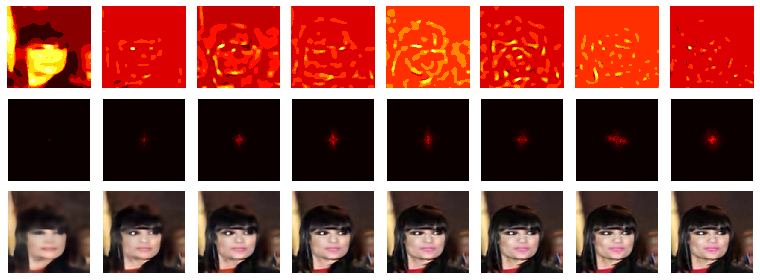

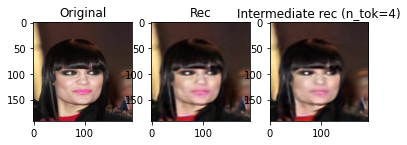

In [38]:
from skimage.color import rgb2gray

postprocess = lambda x: x.moveaxis(0,-1).cpu().detach() + 0.5
inputs, labels = batch
inputs= inputs.cuda()
bs, ch, height, width = inputs.shape

rec = torch.zeros_like(inputs)

n_tokens = MAX_TOKEN
fig, axes = plt.subplots(3,n_tokens, figsize=(n_tokens/3*4,4))
example_idx = 18
a,b = None, None
for j in range(n_tokens): 
    err = inputs-rec
    mean, std = torch.mean(err, dim=(-1,-2), keepdims=True), torch.std(err, dim=(-1,-2), keepdims=True)
    z = enc((err-mean)/std)
    delta = (dec(z)*std + mean)
    rec = rec+delta
    
    hm = np.linalg.norm(postprocess(delta[example_idx]), axis=-1)
    axes[0,j].contourf(hm, cmap='hot', origin='image')
    axes[0,j].axis('off')
    axes[2,j].imshow(postprocess(rec[example_idx]).clamp(0,1), interpolation='none')
    axes[2,j].axis('off')
    
    gr = rgb2gray(delta[example_idx].moveaxis(0,-1).cpu().detach().numpy())
    fft = np.abs(np.fft.fftshift(np.fft.fft2(gr)))**2
    axes[1,j].imshow(fft, origin='lower', interpolation='bilinear', cmap='hot')
    axes[1,j].axis('off')
    
    print(j+1, torch.mean((inputs-rec)[example_idx]**2))
    if j == 4: a = rec.clone()
    if j == 7: b = rec.clone()
fig.tight_layout()
plt.figure()
plt.subplot(131)
plt.title("Original")
plt.imshow(postprocess(inputs[example_idx]))
plt.subplot(132)
plt.title("Rec")
plt.imshow(postprocess(rec[example_idx]))
plt.subplot(133)
plt.title("Intermediate rec (n_tok=4)")
plt.imshow(postprocess(a[example_idx]))

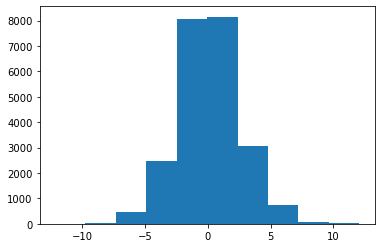

In [28]:
plt.hist(z.cpu().detach().flatten().numpy());